In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
import numpy as np
import pickle
import warnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import nltk 
# from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
# from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
pd.set_option('max_colwidth', 1000)
pd.options.display.max_rows = 500
# Read file
df1 = pd.read_pickle('data_prep.pkl')

In [3]:
kmin, kmax = 4, 50

In [4]:
my_stop_words = text.ENGLISH_STOP_WORDS

vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df = 20)
A = vectorizer.fit_transform(df1['consumer_complaint_narrative'])
terms = vectorizer.get_feature_names()

In [5]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF(random_state =1, init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...
Applying NMF for k=36 ...
Applying NMF for k=37 ...
Applying NMF for k=38 ...
Applying NMF for k=39 ...
Applying NMF for k=40 ...
Applying NMF for k=41 ...
Applying NMF for k

In [6]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [7]:
raw_documents = []
for line in df1['consumer_complaint_narrative']:
    raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 7491 raw text documents


In [8]:
raw_documents[:2]

['due to inconsistencies in the amount owed that i was told by m & t bank and the amount that was reported to the credit reporting agencies, i was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. i had a vehicle that was stolen and it was declared a total loss by insurance company. the insurance company and the gap insurancw companypaid the outstanding balance of the loan, but i was told by m & t bank that there was still a balance due on the loan. in good faith, without having received any proof as to why there was still a balance, i made a partial payment towards the remaining debt. i then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. at one point, in  2015, per my credit monitoring agency, it showed a delinquent balance of $0.00, but when i checked my credit report again on   2015, there 

In [9]:
stop_words = text.ENGLISH_STOP_WORDS

In [10]:
import gensim
docgen = TokenGenerator( raw_documents, stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [11]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 2999 terms


In [12]:
w2v_model.save("w2v-model.bin")

In [13]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [14]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [15]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3233
K=05: Coherence=0.3444
K=06: Coherence=0.3540
K=07: Coherence=0.3589
K=08: Coherence=0.3577
K=09: Coherence=0.3648
K=10: Coherence=0.3601
K=11: Coherence=0.3561
K=12: Coherence=0.3574
K=13: Coherence=0.3825
K=14: Coherence=0.3840
K=15: Coherence=0.3842
K=16: Coherence=0.3883
K=17: Coherence=0.3865
K=18: Coherence=0.3952
K=19: Coherence=0.3968
K=20: Coherence=0.4053
K=21: Coherence=0.4012
K=22: Coherence=0.4054
K=23: Coherence=0.4045
K=24: Coherence=0.4136
K=25: Coherence=0.4109
K=26: Coherence=0.4083
K=27: Coherence=0.4063
K=28: Coherence=0.4064
K=29: Coherence=0.4184
K=30: Coherence=0.4167
K=31: Coherence=0.4258
K=32: Coherence=0.4212
K=33: Coherence=0.4153
K=34: Coherence=0.4110
K=35: Coherence=0.4176
K=36: Coherence=0.4140
K=37: Coherence=0.4180
K=38: Coherence=0.4142
K=39: Coherence=0.4179
K=40: Coherence=0.4138
K=41: Coherence=0.4126
K=42: Coherence=0.4259
K=43: Coherence=0.4103
K=44: Coherence=0.4149
K=45: Coherence=0.4193
K=46: Coherence=0.4102
K=47: Coher

In [16]:
import matplotlib
%mattplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

UsageError: Line magic function `%mattplotlib` not found.


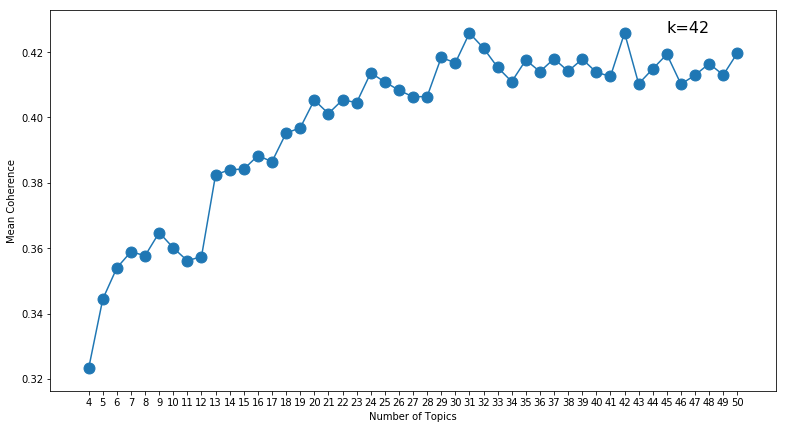

In [17]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [18]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: pay, paid, month, paying, work, just, help, want, time, bills
Topic 02: credit, report, score, reporting, bureaus, reports, removed, reported, bureau, agencies
Topic 03: account, closed, checking, opened, open, close, new, funds, reported, savings
Topic 04: inquiry, fraudulent, view, credit, unauthorized, authorized, personal, remove, immediately, requested
Topic 05: told, said, called, asked, did, got, supervisor, spoke, send, wanted
Topic 06: home, house, help, years, equity, husband, trying, family, lien, foreclosure
Topic 07: card, credit, use, cards, new, citi, debit, purchase, purchases, limit
Topic 08: fargo, wells, funds, income, dealer, charge, bank, line, property, representative
Topic 09: 00, total, 100, month, 15, 1000, 500, 200, paid, 25
Topic 10: mortgage, nationstar, sold, servicing, refinance, new, seterus, current, payoff, house
Topic 11: debt, collector, collect, owe, creditor, original, validation, owed, alleged, recovery
Topic 12: bank, america, boa, branc